# 약물-단백질 상호작용

- 약물과 단백질의 상호작용 정도를 점수화한 데이터를 이용하여 상호작용을 예측하는 머신러닝 모델을 구현
- 약물과 단백질 데이터를 각각 입력으로 사용한다
    1. 약물의 특성과 단백질(타겟)의 특성을 각각 추출하는 모델 구성
    2. 추출된 특성을 **옆으로 붙인(concatenate)** 값을 만드고 이를 DTI 예측 모델 입력으로 사용한다
    3. 상호작용은 이진분류(0/1) 예측(확률) 또는 상호작용 점수 회귀 예측을 하게 된다.
- 약물 재창출 예제

- [DeepPurpose](https://deeppurpose.readthedocs.io/en/latest/notes/introduction.html) 모듈 사용
 - 약물-단백질 상호작용 예측 모델 구현 기능을 제공
 - 가상선별과 약물재창출을 위한 딥러닝 도구

In [1]:
!pip install pandas-flavor
!pip install git+https://github.com/bp-kelley/descriptastorus
!pip install DeepPurpose

  Cloning https://github.com/bp-kelley/descriptastorus to /tmp/pip-req-build-m36q20qt
  Running command git clone --filter=blob:none --quiet https://github.com/bp-kelley/descriptastorus /tmp/pip-req-build-m36q20qt
  Resolved https://github.com/bp-kelley/descriptastorus to commit 86eedc60546abe6f59cdbcb12025a61157ba178d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 17.7 MB/s eta 0:00:00
  Created wheel for descriptastorus: filename=descriptastorus-2.5.0.20-py3-none-any.whl size=1083427 sha256=b3f5ce8329bb565338dd50f79b7cfa2d7d64e667ad7dc56a3b560e5e72f60fae
  Stored in directory: /tmp/pip-ephem-wheel-cache-kieyyvrj/wheels/b0/91/ea/7e8b56f17611c9bebc7f08065799bd317abd64f066463e2e8a
Successfully built descriptastorus
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 

# import

In [2]:
import torch
import DeepPurpose.DTI as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *
import numpy as np
%config InlineBackend.figure_format = 'retina'

# 데이터(이진분류)

In [3]:
# binary 인자를 True로 선택하면 이진 분류 레이블을 사용
X_drug, X_target, y = load_process_DAVIS('./data/', binary=True)

Beginning Processing...
Beginning to extract zip file...
Default binary threshold for the binding affinity scores are 30, you can adjust it by using the "threshold" parameter
Done!


In [6]:
X_drug[:3]

array(['CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N',
       'CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N',
       'CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N'],
      dtype='<U92')

In [7]:
X_target[:3]

array(['MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL',
       'PFWKILNPLLERGTYYYFMG

In [8]:
y[:3]

array([0, 0, 0])

In [9]:
# MLP 모델을 위한 encoding 방식 지정 (입력 특성으로 1차원 벡터를 사용)
drug_encoding = 'Morgan'
target_encoding = 'AAC'
train, val, test = data_process(X_drug, X_target, y,
                                drug_encoding, target_encoding,
                                split_method='random',frac=[0.8,0.1,0.1])

Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 379
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.
splitting dataset...
Done.


In [10]:
train[:3]

,SMILES,Target Sequence,Label,drug_encoding,target_encoding
0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.221, 3.33, 3.434, 4.683, 1.353, 4.475, 11.6..."
1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.483, 5.827, 3.599, 3.685, 1.028, 7.798, 3.0..."
2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.483, 5.827, 3.599, 3.685, 1.028, 7.798, 3.0..."


In [ ]:
# num = 9
# print('Drug 1: ' + X_drug[num])
# print('Target 1: ' + X_target[num])
# print('Score 1: ' + str(y[num]))

Drug 1: CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N
Target 1: PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLS

In [11]:
# 모델 다운로드
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1v9L5hL3w6SIkZ_iwNxbgwCEO8hmVhSX6' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1v9L5hL3w6SIkZ_iwNxbgwCEO8hmVhSX6" -O models.zip && rm -rf ~/cookies.txt

--2023-07-26 02:50:53--  https://docs.google.com/uc?export=download&confirm=t&id=1v9L5hL3w6SIkZ_iwNxbgwCEO8hmVhSX6
Resolving docs.google.com (docs.google.com)... 142.250.148.102, 142.250.148.101, 142.250.148.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.148.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/off5ru73nb4f9s2t6j384ds1r501rvoj/1690339800000/07131861431613450544/*/1v9L5hL3w6SIkZ_iwNxbgwCEO8hmVhSX6?e=download&uuid=7e5e9332-d54d-46be-aa34-afb7d4e2450e [following]
--2023-07-26 02:50:53--  https://doc-0k-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/off5ru73nb4f9s2t6j384ds1r501rvoj/1690339800000/07131861431613450544/*/1v9L5hL3w6SIkZ_iwNxbgwCEO8hmVhSX6?e=download&uuid=7e5e9332-d54d-46be-aa34-afb7d4e2450e
Resolving doc-0k-68-docs.googleusercontent.com (doc-0k-68-docs.googleusercontent.com)... 142.251.172.

In [12]:
# 다운받은 모델 압축해제
!unzip models.zip

Archive:  models.zip
   creating: model_cnn_cnn_davis_bi/
  inflating: model_cnn_cnn_davis_bi/config.pkl  
  inflating: model_cnn_cnn_davis_bi/model.pt  
   creating: model_mlp_mlp_davis_bi/
  inflating: model_mlp_mlp_davis_bi/config.pkl  
  inflating: model_mlp_mlp_davis_bi/model.pt  
   creating: model_mlp_mlp_davis_reg/
  inflating: model_mlp_mlp_davis_reg/config.pkl  
  inflating: model_mlp_mlp_davis_reg/model.pt  


# MLP 모델 사용

## 모델 정의 및 학습

In [13]:
# 모델 정의
config = generate_config(drug_encoding = drug_encoding, # encoding 옵션에 따라 모델 레이어가 설정됨
                         target_encoding = target_encoding,
                         cls_hidden_dims = [1024,1024,512], # 모델 구조 정의
                         train_epoch = 100, # epoch 횟수
                         LR = 0.001, # 학습률 지정
                         batch_size = 256 # 배치사이즈 지정
                        )
model = models.model_initialize(**config)
# 모델 구조 보기
print(model.model)

Classifier(
  (model_drug): MLP(
    (predictor): ModuleList(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=256, bias=True)
    )
  )
  (model_protein): MLP(
    (predictor): ModuleList(
      (0): Linear(in_features=8420, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=256, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)


Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69586. Total time 0.00083 hours
Validation at Epoch 1, AUROC: 0.85652 , AUPRC: 0.30333 , F1: 0.24242 , Cross-entropy Loss: 1.79858
Training at Epoch 2 iteration 0 with loss 0.12390. Total time 0.0025 hours
Validation at Epoch 2, AUROC: 0.88784 , AUPRC: 0.37282 , F1: 0.2 , Cross-entropy Loss: 1.72664
Training at Epoch 3 iteration 0 with loss 0.08781. Total time 0.00416 hours
Validation at Epoch 3, AUROC: 0.88433 , AUPRC: 0.35929 , F1: 0.17877 , Cross-entropy Loss: 1.76261
Training at Epoch 4 iteration 0 with loss 0.12751. Total time 0.00611 hours
Validation at Epoch 4, AUROC: 0.87652 , AUPRC: 0.38202 , F1: 0.19318 , Cross-entropy Loss: 1.70266
Training at Epoch 5 iteration 0 with loss 0.19867. Total time 0.00777 hours
Validation at Epoch 5, AUROC: 0.88357 , AUPRC: 0.42744 , F1: 0.19653 , Cross-entropy Loss: 1.66668
Training at Epoch 6 iteration 0 with loss 0.12520. Total time 0.

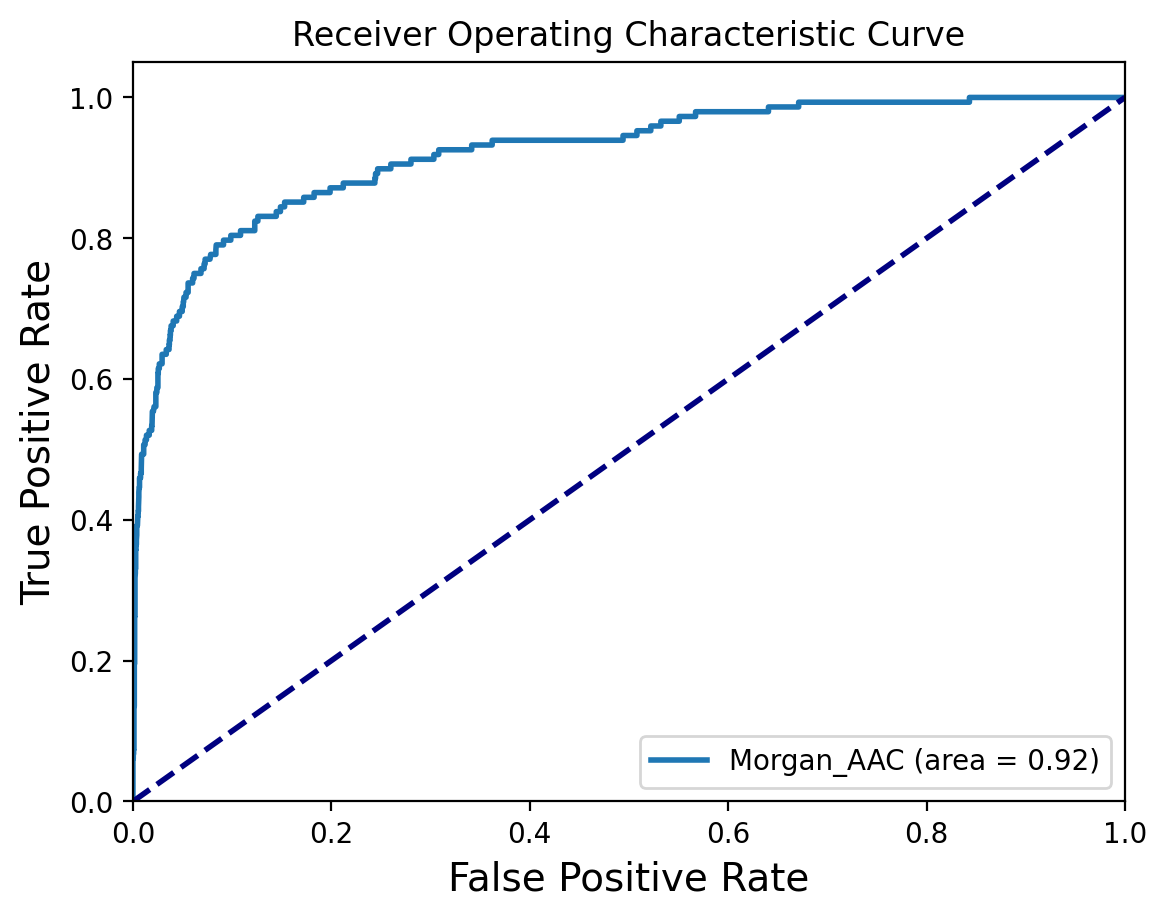

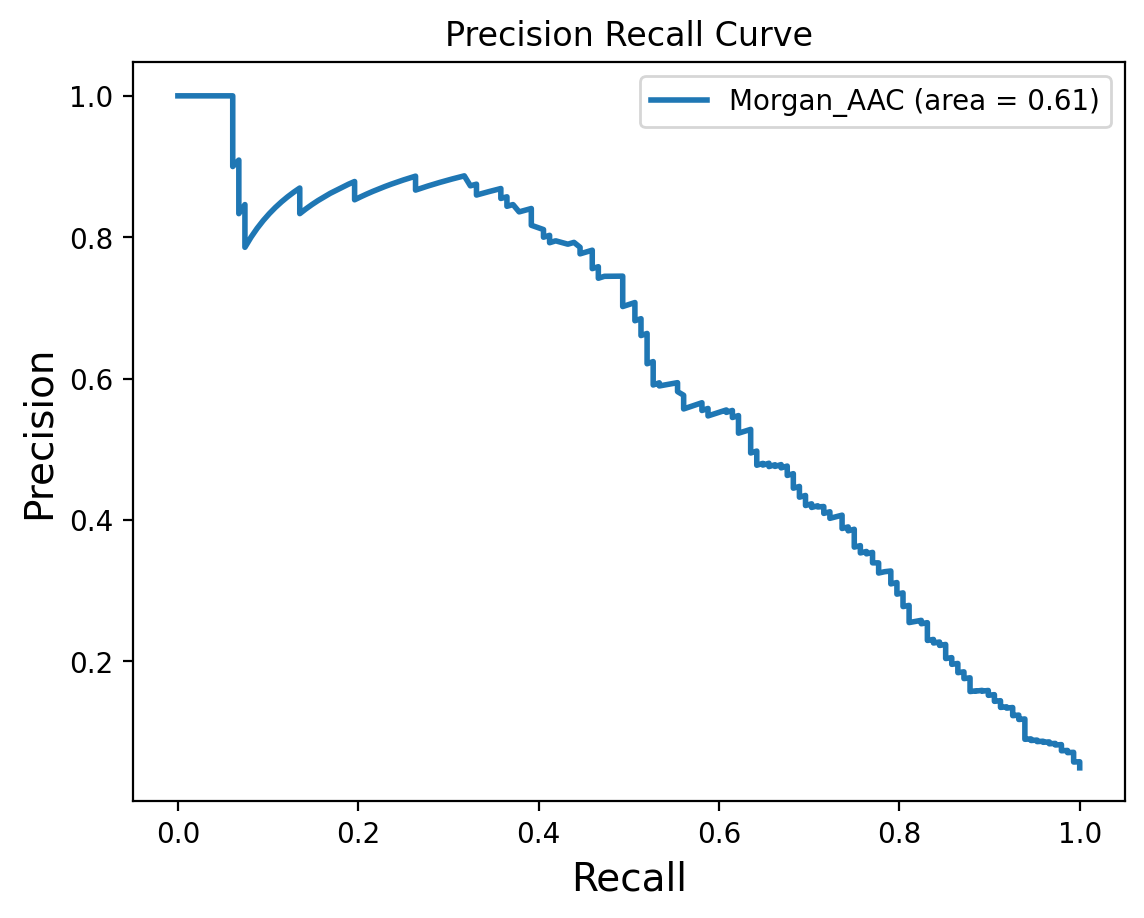

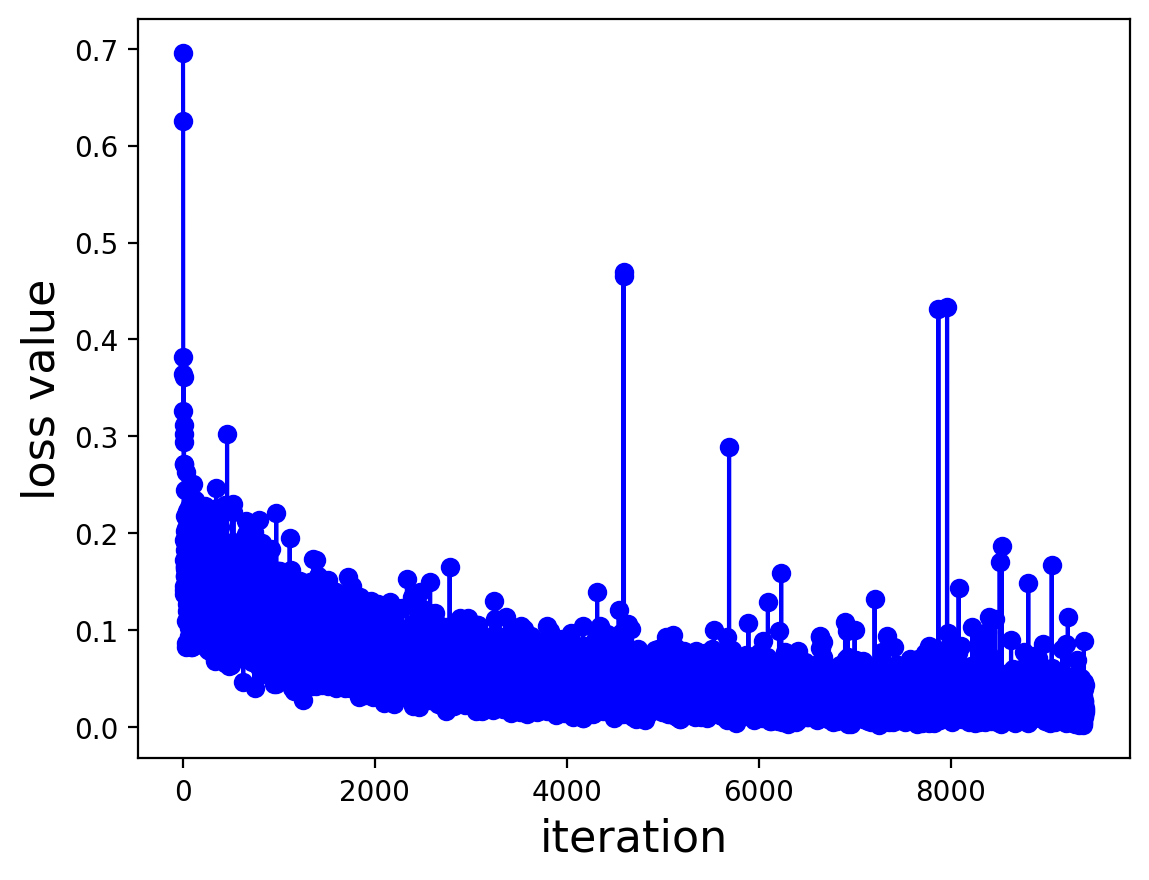

In [14]:
# 학습시간이 오래 걸린다 (11분)
# 백업된 모델을 사용하겠다
model.train(train, val, test)

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
!cp /content/drive/MyDrive/DTI_models.zip .

In [ ]:
# 다른 방법: 백업된 학습 모델 다운로드
# !wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1v9L5hL3w6SIkZ_iwNxbgwCEO8hmVhSX6' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1v9L5hL3w6SIkZ_iwNxbgwCEO8hmVhSX6" -O models.zip && rm -rf ~/cookies.txt

--2023-07-26 02:50:53--  https://docs.google.com/uc?export=download&confirm=t&id=1v9L5hL3w6SIkZ_iwNxbgwCEO8hmVhSX6
Resolving docs.google.com (docs.google.com)... 142.250.148.102, 142.250.148.101, 142.250.148.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.148.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/off5ru73nb4f9s2t6j384ds1r501rvoj/1690339800000/07131861431613450544/*/1v9L5hL3w6SIkZ_iwNxbgwCEO8hmVhSX6?e=download&uuid=7e5e9332-d54d-46be-aa34-afb7d4e2450e [following]
--2023-07-26 02:50:53--  https://doc-0k-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/off5ru73nb4f9s2t6j384ds1r501rvoj/1690339800000/07131861431613450544/*/1v9L5hL3w6SIkZ_iwNxbgwCEO8hmVhSX6?e=download&uuid=7e5e9332-d54d-46be-aa34-afb7d4e2450e
Resolving doc-0k-68-docs.googleusercontent.com (doc-0k-68-docs.googleusercontent.com)... 142.251.172.

In [19]:
# 다운받은 모델 압축해제
!unzip DTI_models.zip

Archive:  DTI_models.zip
replace model_cnn_cnn_davis_bi/config.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# 학습된 모델 다운로드

## 결과 확인

In [22]:
# 결과가 저장된 파일을 읽어 성능 지표값을 반환하는 함수
def get_test_result(binary=True):
    with open('./result/test_markdowntable.txt', 'r') as f:
        if binary:
            result = f.readlines()[-2].replace(' ', '').split('|')
            AUROC, AUPRC, F1 = result[1], result[2], result[3]
            return AUROC, AUPRC, F1
        else:
            result = f.readlines()[-2].replace(' ', '').split('|')
            MSE, Pearson_Correlation, p_value, Concordance_Index = result[1], result[2], result[3], result[4]
            return MSE, Pearson_Correlation, p_value, Concordance_Index

In [20]:
!cat ./result/test_markdowntable.txt

+--------+--------+--------+
| AUROC  | AUPRC  |   F1   |
+--------+--------+--------+
| 0.9211 | 0.6082 | 0.5571 |
+--------+--------+--------+

In [23]:
AUROC, AUPRC, F1 = get_test_result(binary=True)
print(f'AUROC : {AUROC}')
print(f'AUPRC : {AUPRC}')
print(f'F1 : {F1}')

AUROC : 0.9211
AUPRC : 0.6082
F1 : 0.5571


### 학습된 모델 저장 또는 불러오기

In [24]:
# 학습시킨 모델 저장하기
# model.save_model('./model_mlp_mlp_davis_bi')

In [25]:
# 백업 모델 불러오기
model = models.model_pretrained('./model_mlp_mlp_davis_bi')
model.model

Classifier(
  (model_drug): MLP(
    (predictor): ModuleList(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=256, bias=True)
    )
  )
  (model_protein): MLP(
    (predictor): ModuleList(
      (0): Linear(in_features=8420, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=256, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)

### 모델 성능 검증

Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.05539. Total time 0.0 hours
Validation at Epoch 1, AUROC: 0.93941 , AUPRC: 0.66211 , F1: 0.64285 , Cross-entropy Loss: 1.07915
--- Go for Testing ---
Validation at Epoch 1 , AUROC: 0.91487 , AUPRC: 0.57830 , F1: 0.59927 , Cross-entropy Loss: 1.33095
--- Training Finished ---


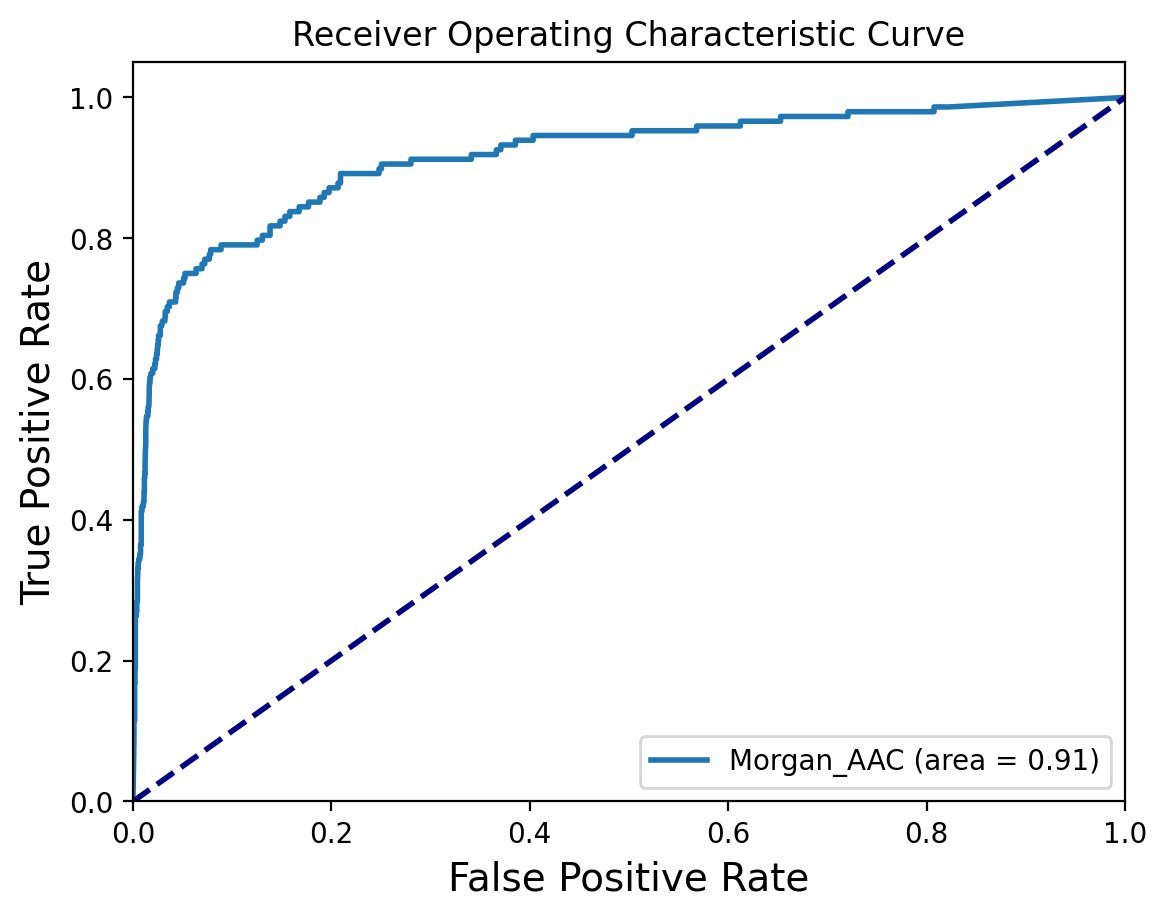

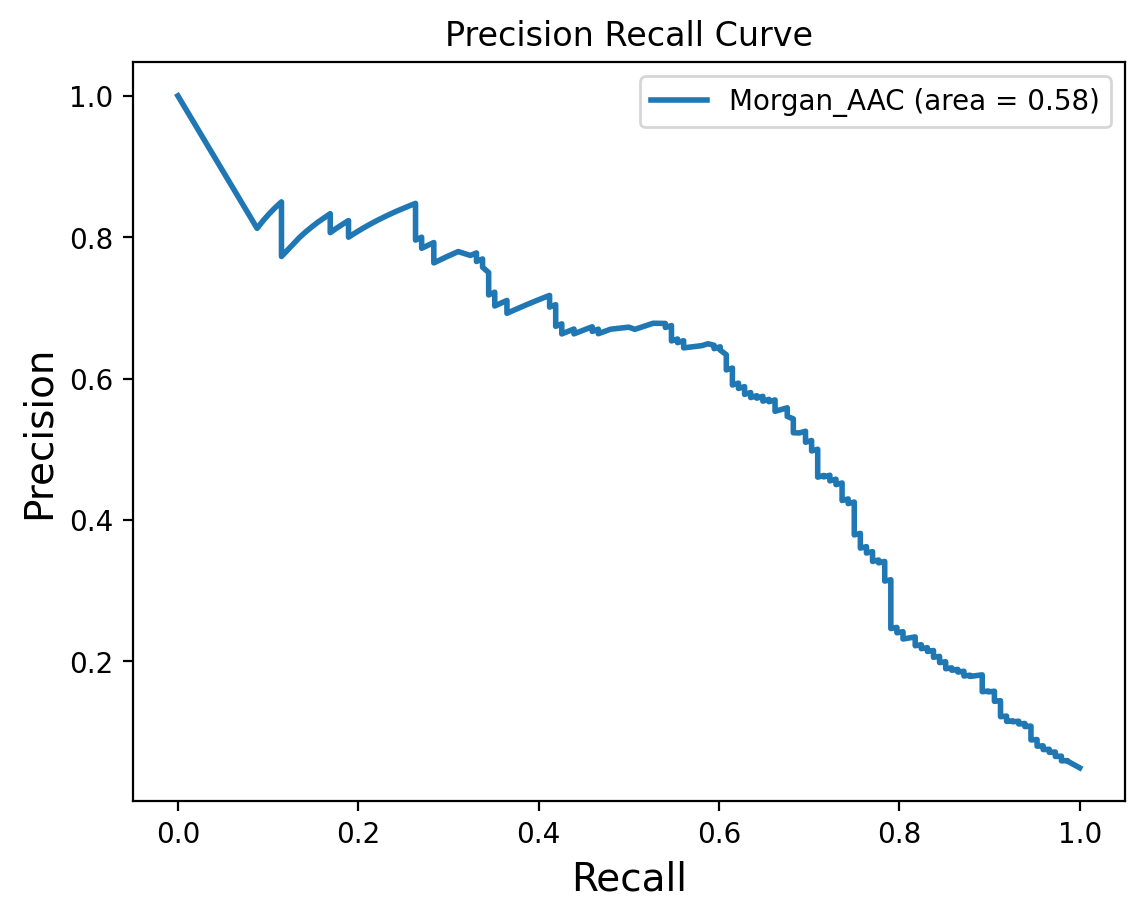

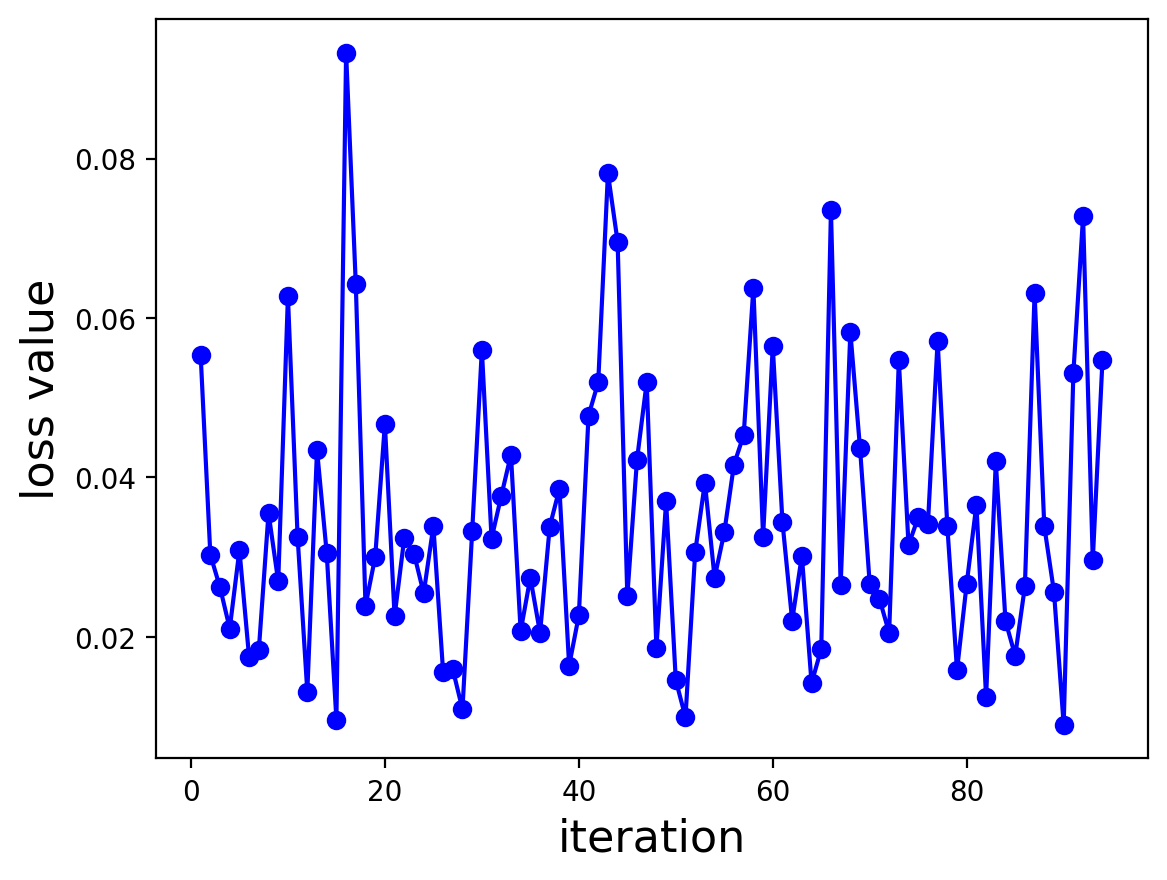

In [26]:
model.config['train_epoch'] = 1
model.train(train, val, test)

# CNN 모델 사용

## 모델 정의 및 학습

In [ ]:
drug_encoding = 'CNN'
target_encoding = 'CNN'
train, val, test = data_process(X_drug, X_target, y,
                                drug_encoding, target_encoding,
                                split_method='random',frac=[0.8,0.1,0.1])


config = generate_config(drug_encoding = drug_encoding,# encoding 옵션에 따라 모델 레이어가 설정됨
                         target_encoding = target_encoding,
                         cls_hidden_dims = [1024,1024,512], # 모델 말단의 예측 레이어의 구조 정의
                         train_epoch = 100, # 모델 학습 시 반복 횟수 지정
                         LR = 0.001, # 학습률 지정
                         batch_size = 256, # 배치사이즈 지정
                         cnn_drug_filters = [32,64,96], # 약물 레이어의 cnn 필터 개수 지정
                         cnn_target_filters = [32,64,96], # 타겟 레이어의 cnn 핕터 개수 지정
                         cnn_drug_kernels = [4,6,8], # 약물 레이어의 커널 사이즈 지정
                         cnn_target_kernels = [4,8,12] # 타겟 레이어의 커널 사이즈 지정
                        )

model = models.model_initialize(**config)
# 모델 구조 보기
print(model.model)

Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 379
splitting dataset...
Done.
Classifier(
  (model_drug): CNN(
    (conv): ModuleList(
      (0): Conv1d(63, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 64, kernel_size=(6,), stride=(1,))
      (2): Conv1d(64, 96, kernel_size=(8,), stride=(1,))
    )
    (fc1): Linear(in_features=96, out_features=256, bias=True)
  )
  (model_protein): CNN(
    (conv): ModuleList(
      (0): Conv1d(26, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
      (2): Conv1d(64, 96, kernel_size=(12,), stride=(1,))
    )
    (fc1): Linear(in_features=96, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_feat

Let's use 2 GPUs!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.70481. Total time 0.0 hours
Validation at Epoch 1, AUROC: 0.83996 , AUPRC: 0.27639 , F1: 0.0 , Cross-entropy Loss: 1.71200
Training at Epoch 2 iteration 0 with loss 0.18051. Total time 0.01944 hours
Validation at Epoch 2, AUROC: 0.87322 , AUPRC: 0.35533 , F1: 0.0 , Cross-entropy Loss: 1.71200
Training at Epoch 3 iteration 0 with loss 0.14139. Total time 0.03888 hours
Validation at Epoch 3, AUROC: 0.88586 , AUPRC: 0.35638 , F1: 0.03921 , Cross-entropy Loss: 1.68902
Training at Epoch 4 iteration 0 with loss 0.12764. Total time 0.05805 hours
Validation at Epoch 4, AUROC: 0.88951 , AUPRC: 0.39594 , F1: 0.22580 , Cross-entropy Loss: 1.65455
Training at Epoch 5 iteration 0 with loss 0.13224. Total time 0.0775 hours
Validation at Epoch 5, AUROC: 0.89040 , AUPRC: 0.43016 , F1: 0.31627 , Cross-entropy Loss: 1.68903
Training at Epoch 6 iteration 0 with loss 0.13688. Total time 0.09694 h

Validation at Epoch 47, AUROC: 0.95215 , AUPRC: 0.67415 , F1: 0.65427 , Cross-entropy Loss: 1.06857
Training at Epoch 48 iteration 0 with loss 0.03516. Total time 0.91111 hours
Validation at Epoch 48, AUROC: 0.94164 , AUPRC: 0.66417 , F1: 0.61003 , Cross-entropy Loss: 1.16049
Training at Epoch 49 iteration 0 with loss 0.07081. Total time 0.93083 hours
Validation at Epoch 49, AUROC: 0.94887 , AUPRC: 0.64404 , F1: 0.61832 , Cross-entropy Loss: 1.14900
Training at Epoch 50 iteration 0 with loss 0.05567. Total time 0.95027 hours
Validation at Epoch 50, AUROC: 0.94499 , AUPRC: 0.65034 , F1: 0.63082 , Cross-entropy Loss: 1.18347
Training at Epoch 51 iteration 0 with loss 0.04321. Total time 0.96972 hours
Validation at Epoch 51, AUROC: 0.94616 , AUPRC: 0.66468 , F1: 0.63197 , Cross-entropy Loss: 1.13751
Training at Epoch 52 iteration 0 with loss 0.06402. Total time 0.98888 hours
Validation at Epoch 52, AUROC: 0.94035 , AUPRC: 0.66715 , F1: 0.62093 , Cross-entropy Loss: 1.20645
Training at Epo

Training at Epoch 94 iteration 0 with loss 0.03614. Total time 1.80138 hours
Validation at Epoch 94, AUROC: 0.94570 , AUPRC: 0.66050 , F1: 0.58365 , Cross-entropy Loss: 1.22943
Training at Epoch 95 iteration 0 with loss 0.02660. Total time 1.82083 hours
Validation at Epoch 95, AUROC: 0.93529 , AUPRC: 0.62787 , F1: 0.60674 , Cross-entropy Loss: 1.20645
Training at Epoch 96 iteration 0 with loss 0.01897. Total time 1.84027 hours
Validation at Epoch 96, AUROC: 0.93539 , AUPRC: 0.60262 , F1: 0.59854 , Cross-entropy Loss: 1.26390
Training at Epoch 97 iteration 0 with loss 0.01748. Total time 1.85944 hours
Validation at Epoch 97, AUROC: 0.93784 , AUPRC: 0.61582 , F1: 0.56589 , Cross-entropy Loss: 1.28688
Training at Epoch 98 iteration 0 with loss 0.02162. Total time 1.87888 hours
Validation at Epoch 98, AUROC: 0.93967 , AUPRC: 0.62163 , F1: 0.60240 , Cross-entropy Loss: 1.13751
Training at Epoch 99 iteration 0 with loss 0.03449. Total time 1.89805 hours
Validation at Epoch 99, AUROC: 0.93507

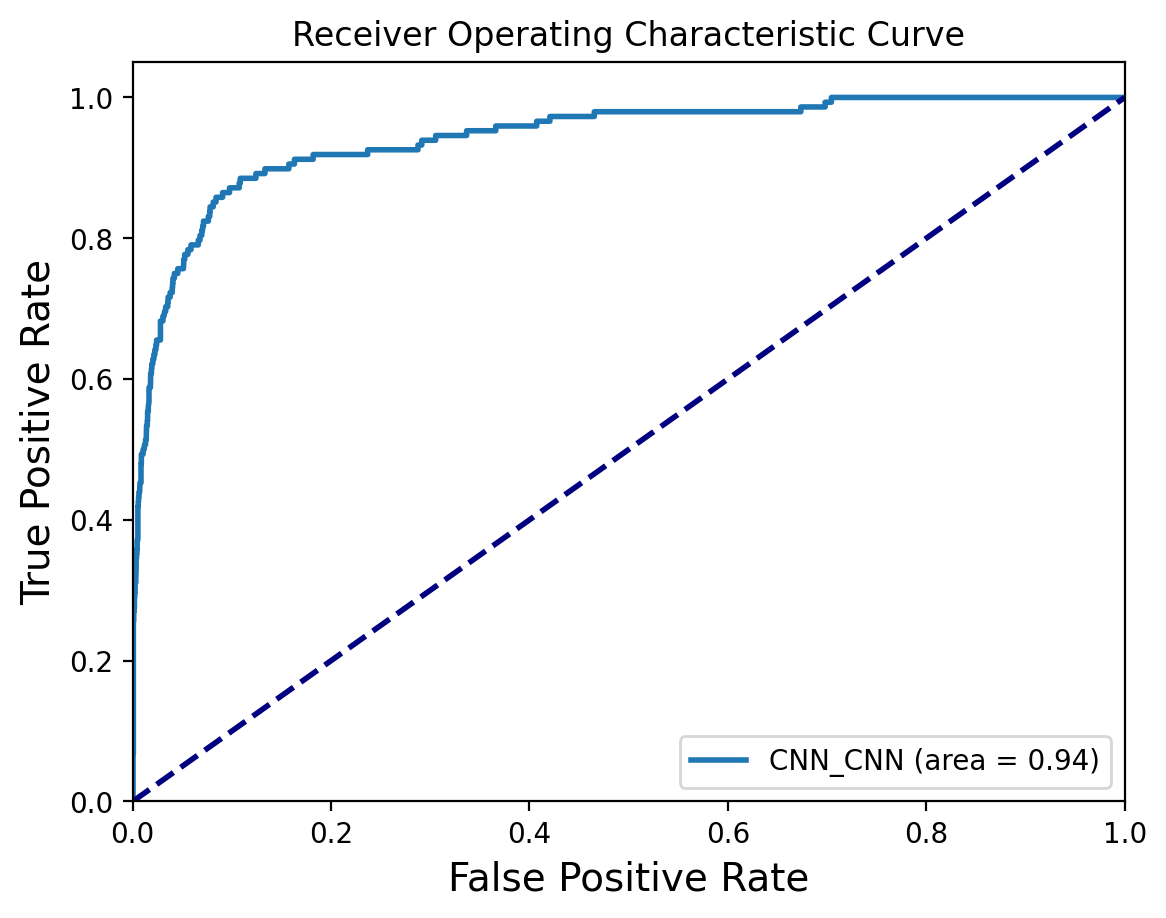

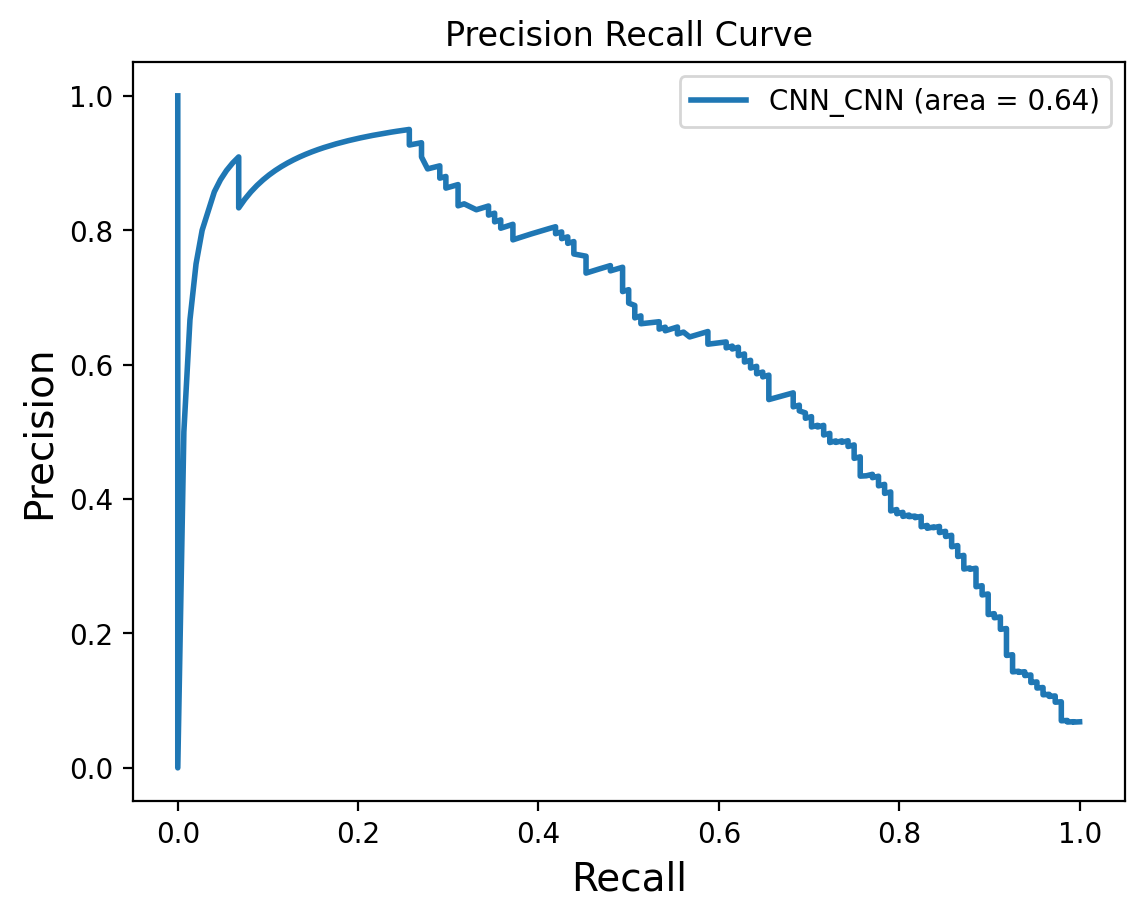

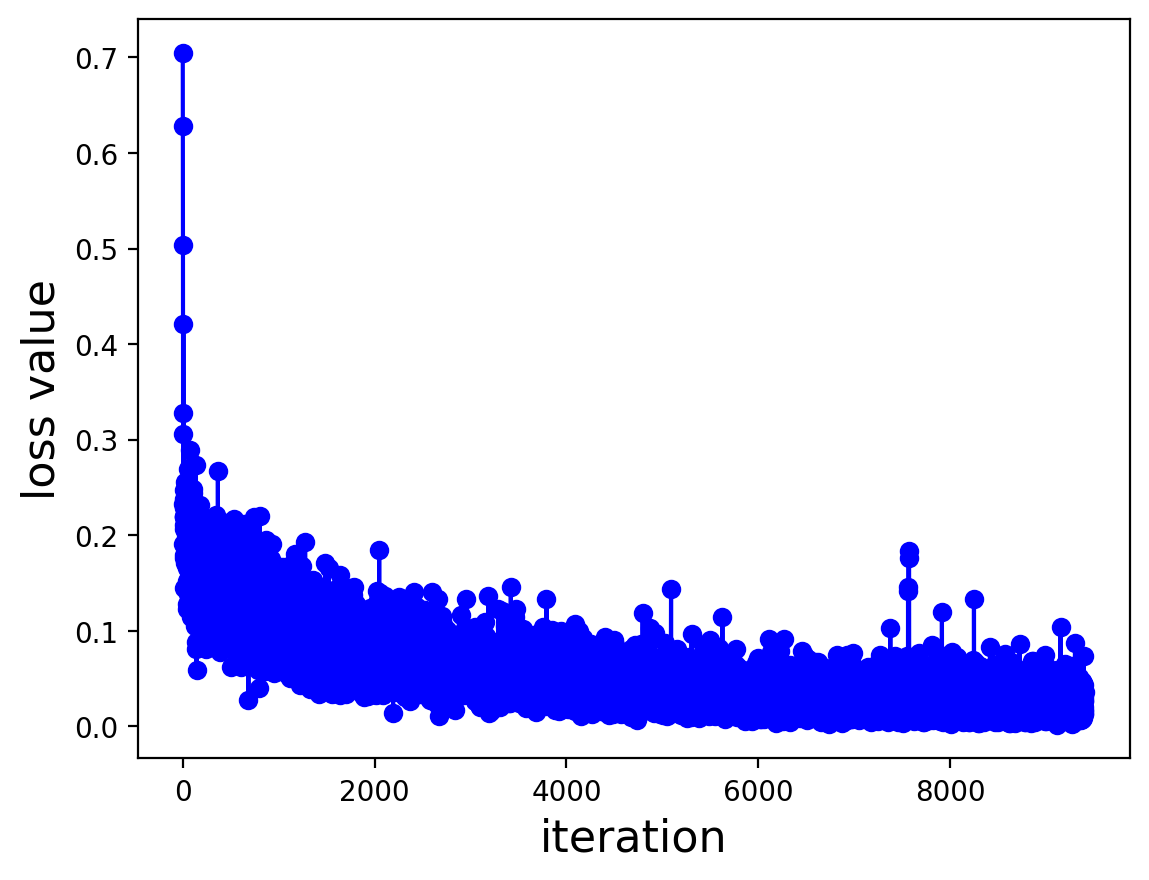

In [ ]:
# 시간이 오래 걸린다
# model.train(train, val, test)

### 결과 확인

In [ ]:
!cat ./result/test_markdowntable.txt

+--------+--------+--------+
| AUROC  | AUPRC  |   F1   |
+--------+--------+--------+
| 0.9426 | 0.6413 | 0.5985 |
+--------+--------+--------+

In [ ]:
AUROC, AUPRC, F1 = get_test_result(binary=True)
print(f'AUROC : {AUROC}')
print(f'AUPRC : {AUPRC}')
print(f'F1 : {F1}')

### 학습된 모델 저장 및 불러오기

In [ ]:
# 모델 저장
# model.save_model('./model_cnn_cnn_davis_bi')

In [ ]:
# 모델 불러오기
model = models.model_pretrained('./model_cnn_cnn_davis_bi')
model.model

Classifier(
  (model_drug): CNN(
    (conv): ModuleList(
      (0): Conv1d(63, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 64, kernel_size=(6,), stride=(1,))
      (2): Conv1d(64, 96, kernel_size=(8,), stride=(1,))
    )
    (fc1): Linear(in_features=96, out_features=256, bias=True)
  )
  (model_protein): CNN(
    (conv): ModuleList(
      (0): Conv1d(26, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
      (2): Conv1d(64, 96, kernel_size=(12,), stride=(1,))
    )
    (fc1): Linear(in_features=96, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)

### 모델 성능 검증

Let's use 2 GPUs!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.03282. Total time 0.0 hours
Validation at Epoch 1, AUROC: 0.94540 , AUPRC: 0.67582 , F1: 0.60966 , Cross-entropy Loss: 1.20645
--- Go for Testing ---
Validation at Epoch 1 , AUROC: 0.93807 , AUPRC: 0.63809 , F1: 0.62815 , Cross-entropy Loss: 1.18347
--- Training Finished ---


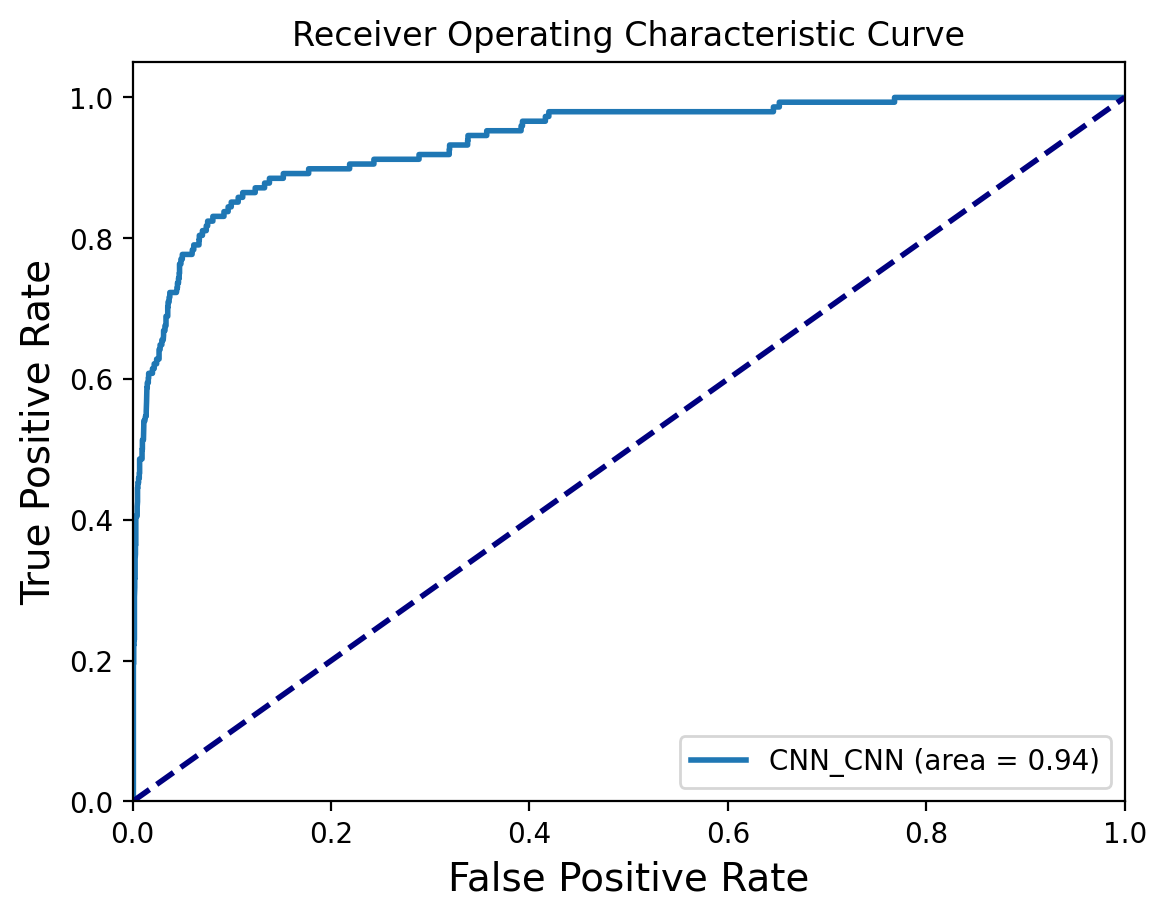

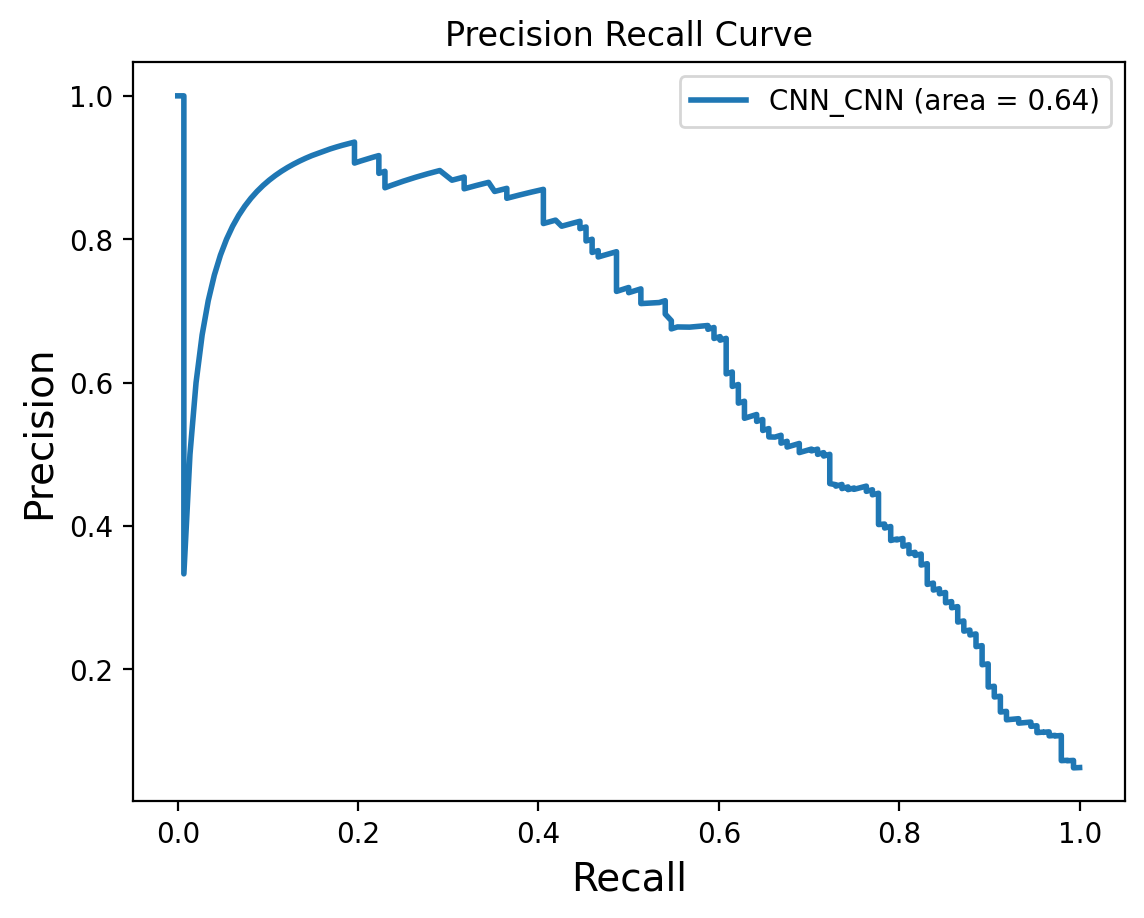

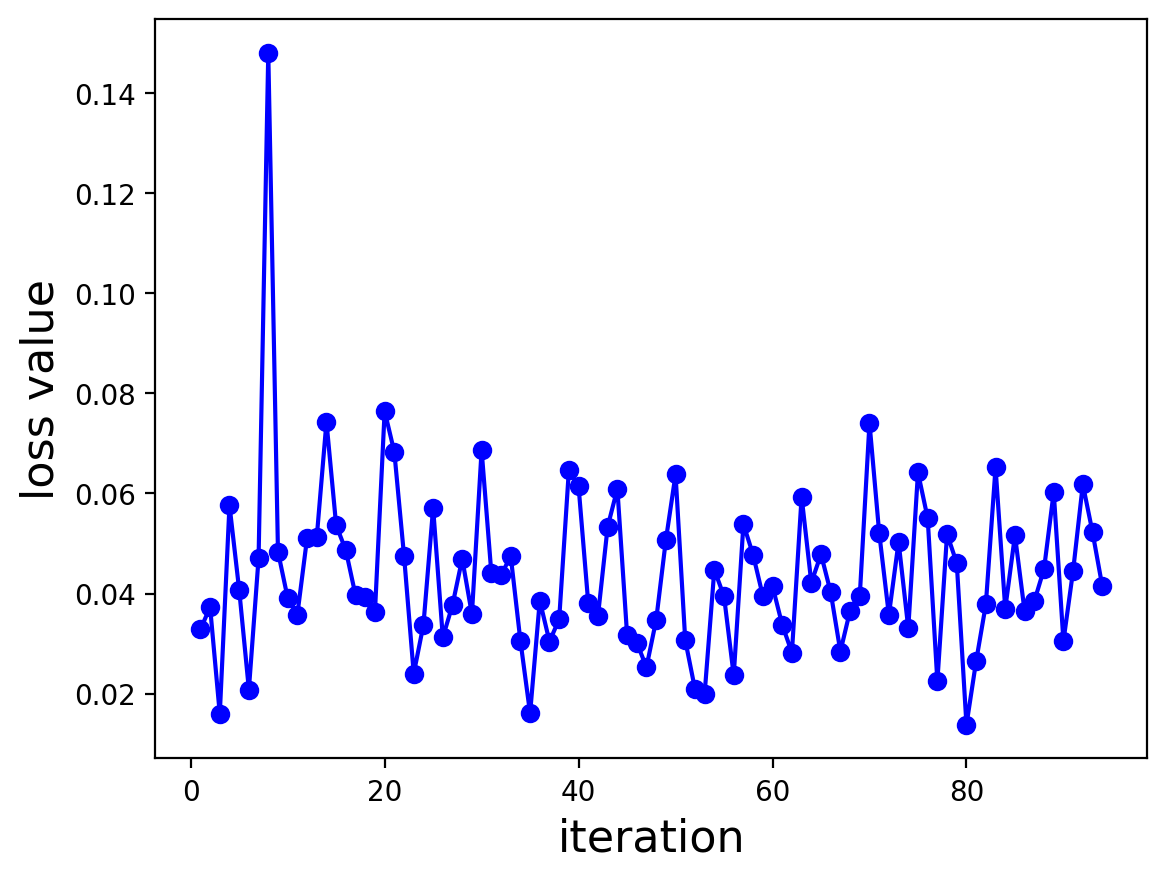

In [ ]:
model.config['train_epoch'] = 1
model.train(train, val, test)

# 데이터(회귀)

In [ ]:
# binary인자를 False로 하면 Label이 결합 정도에 따라 점수로 표시
X_drug, X_target, y = load_process_DAVIS('./data/', binary=False)

# MLP 모델을 위한 encoding 방식 지정 (입력 특성으로 1차원 벡터를 사용)
drug_encoding = 'Morgan'
target_encoding = 'AAC'
train, val, test = data_process(X_drug, X_target, y,
                                drug_encoding, target_encoding,
                                split_method='random',frac=[0.8,0.1,0.1])

Beginning Processing...
100% [........................................................] 179878 / 179878Beginning to extract zip file...
Default set to logspace (nM -> p) for easier regression
Done!
Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 379
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.
splitting dataset...
Done.


## 데이터 확인

In [ ]:
# Label 표시가 변경됨을 확인
train

,SMILES,Target Sequence,Label,drug_encoding,target_encoding
0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.366532,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.221, 3.33, 3.434, 4.683, 1.353, 4.475, 11.6..."
1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.483, 5.827, 3.599, 3.685, 1.028, 7.798, 3.0..."
2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.483, 5.827, 3.599, 3.685, 1.028, 7.798, 3.0..."
3,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.483, 5.827, 3.599, 3.685, 1.028, 7.798, 3.0..."
4,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.483, 5.827, 3.599, 3.685, 1.028, 7.798, 3.0..."
...,...,...,...,...,...
24039,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MRSGAERRGSSAAASPGSPPPGRARPAGSDAPSALPPPAAGQPRAR...,5.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.025, 7.819, 3.086, 6.996, 1.44, 7.202, 4.52..."
24040,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MGCIKSKENKSPAIKYRPENTPEPVSTSVSHYGAEPTTVSPCPSSS...,5.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.814, 4.788, 3.499, 4.42, 1.657, 7.735, 3.49..."
24041,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...,5.721246,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.765, 4.593, 5.648, 4.367, 2.033, 9.036, 4.6..."
24042,C1=CC=C2C(=C1)C(=NN=C2NC3=CC=C(C=C3)Cl)CC4=CC=...,MSSLGASFVQIKFDDLQFFENCGGGSFGSVYRAKWISQDKEVAVKK...,5.356547,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.5, 5.875, 4.125, 5.375, 1.375, 7.375, 4.125..."


## MLP 모델 사용

### 모델 정의 및 학습

Let's use 2 GPUs!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 30.8957. Total time 0.0 hours
Validation at Epoch 1 with loss:0.45564, MSE: 0.54796 , Pearson Correlation: 0.56720 with p-value: 1.52E-255 , Concordance Index: 0.79216
Training at Epoch 2 iteration 0 with loss 0.67423. Total time 0.00305 hours
Validation at Epoch 2 with loss:0.65255, MSE: 0.52204 , Pearson Correlation: 0.58055 with p-value: 1.85E-270 , Concordance Index: 0.79982
Training at Epoch 3 iteration 0 with loss 0.57406. Total time 0.00611 hours
Validation at Epoch 3 with loss:0.59093, MSE: 0.52462 , Pearson Correlation: 0.57989 with p-value: 1.05E-269 , Concordance Index: 0.80509
Training at Epoch 4 iteration 0 with loss 0.66646. Total time 0.00888 hours
Validation at Epoch 4 with loss:0.54239, MSE: 0.49683 , Pearson Correlation: 0.60378 with p-value: 4.00E-298 , Concordance Index: 0.81089
Training at Epoch 5 iteration 0 with loss 0.60644. Total time 0.01166 hours
Valid

Validation at Epoch 39 with loss:0.25506, MSE: 0.30620 , Pearson Correlation: 0.79708 with p-value: 0.00E+00 , Concordance Index: 0.87050
Training at Epoch 40 iteration 0 with loss 0.25289. Total time 0.11861 hours
Validation at Epoch 40 with loss:0.34089, MSE: 0.29983 , Pearson Correlation: 0.78654 with p-value: 0.00E+00 , Concordance Index: 0.86016
Training at Epoch 41 iteration 0 with loss 0.26697. Total time 0.12166 hours
Validation at Epoch 41 with loss:0.28145, MSE: 0.27973 , Pearson Correlation: 0.80235 with p-value: 0.00E+00 , Concordance Index: 0.87588
Training at Epoch 42 iteration 0 with loss 0.27086. Total time 0.12472 hours
Validation at Epoch 42 with loss:0.27612, MSE: 0.28457 , Pearson Correlation: 0.79935 with p-value: 0.00E+00 , Concordance Index: 0.86999
Training at Epoch 43 iteration 0 with loss 0.26499. Total time 0.12777 hours
Validation at Epoch 43 with loss:0.28728, MSE: 0.27992 , Pearson Correlation: 0.80104 with p-value: 0.00E+00 , Concordance Index: 0.86905
Tr

Validation at Epoch 78 with loss:0.31468, MSE: 0.24815 , Pearson Correlation: 0.82882 with p-value: 0.00E+00 , Concordance Index: 0.88659
Training at Epoch 79 iteration 0 with loss 0.16658. Total time 0.23861 hours
Validation at Epoch 79 with loss:0.29588, MSE: 0.27267 , Pearson Correlation: 0.82205 with p-value: 0.00E+00 , Concordance Index: 0.87579
Training at Epoch 80 iteration 0 with loss 0.24352. Total time 0.24166 hours
Validation at Epoch 80 with loss:0.22912, MSE: 0.25568 , Pearson Correlation: 0.82090 with p-value: 0.00E+00 , Concordance Index: 0.87582
Training at Epoch 81 iteration 0 with loss 0.15257. Total time 0.24444 hours
Validation at Epoch 81 with loss:0.29015, MSE: 0.25555 , Pearson Correlation: 0.82334 with p-value: 0.00E+00 , Concordance Index: 0.88016
Training at Epoch 82 iteration 0 with loss 0.21252. Total time 0.24777 hours
Validation at Epoch 82 with loss:0.27041, MSE: 0.26687 , Pearson Correlation: 0.82367 with p-value: 0.00E+00 , Concordance Index: 0.88511
Tr

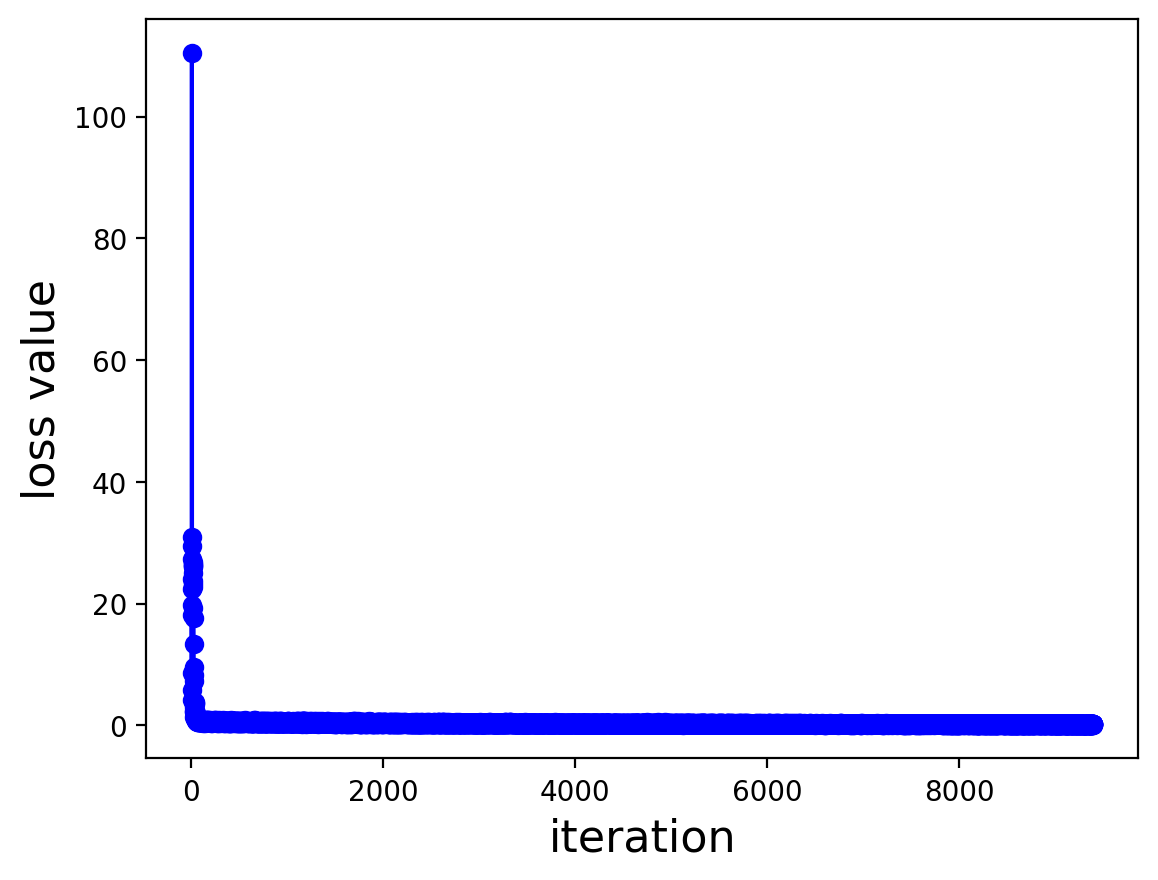

In [ ]:
# 모델 정의
config = generate_config(drug_encoding = drug_encoding, # encoding 옵션에 따라 모델 레이어가 설정됨
                         target_encoding = target_encoding,
                         cls_hidden_dims = [1024,1024,512], # 모델 말단의 예측 레이어의 구조 정의
                         train_epoch = 100, # 모델 학습 시 반복 횟수 지정
                         LR = 0.001, # 학습률 지정
                         batch_size = 256 # 배치사이즈 지정
                        )
model = models.model_initialize(**config)
# 모델 학습
# model.train(train, val, test)

### 결과 확인

In [ ]:
!cat ./result/test_markdowntable.txt

+--------+---------------------+--------------+-------------------+
|  MSE   | Pearson Correlation | with p-value | Concordance Index |
+--------+---------------------+--------------+-------------------+
| 0.2411 |        0.8350       |    0.0000    |       0.8774      |
+--------+---------------------+--------------+-------------------+

In [ ]:
MSE, Pearson_Correlation, p_value, Concordance_Index = get_test_result(binary=False)
print(f'MSE : {MSE}')
print(f'Pearson_Correlation : {Pearson_Correlation}')
print(f'p_value : {p_value}')
print(f'Concordance_Index : {Concordance_Index}')

### 학습된 모델 저장 및 불러오기

In [ ]:
# 모델 저장
# model.save_model('./model_mlp_mlp_davis_reg')

In [ ]:
# 모델 불러오기
model = models.model_pretrained('./model_mlp_mlp_davis_reg')
model.model

Classifier(
  (model_drug): MLP(
    (predictor): ModuleList(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=256, bias=True)
    )
  )
  (model_protein): MLP(
    (predictor): ModuleList(
      (0): Linear(in_features=8420, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=256, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)

### 불러온 모델 성능 검증

Let's use 2 GPUs!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.17816. Total time 0.0 hours
Validation at Epoch 1 with loss:0.12894, MSE: 0.24446 , Pearson Correlation: 0.82892 with p-value: 0.00E+00 , Concordance Index: 0.87970
--- Go for Testing ---
Testing MSE: 0.2426580092825028 , Pearson Correlation: 0.8327334939757502 with p-value: 0.00E+00 , Concordance Index: 0.8785147111411744
--- Training Finished ---


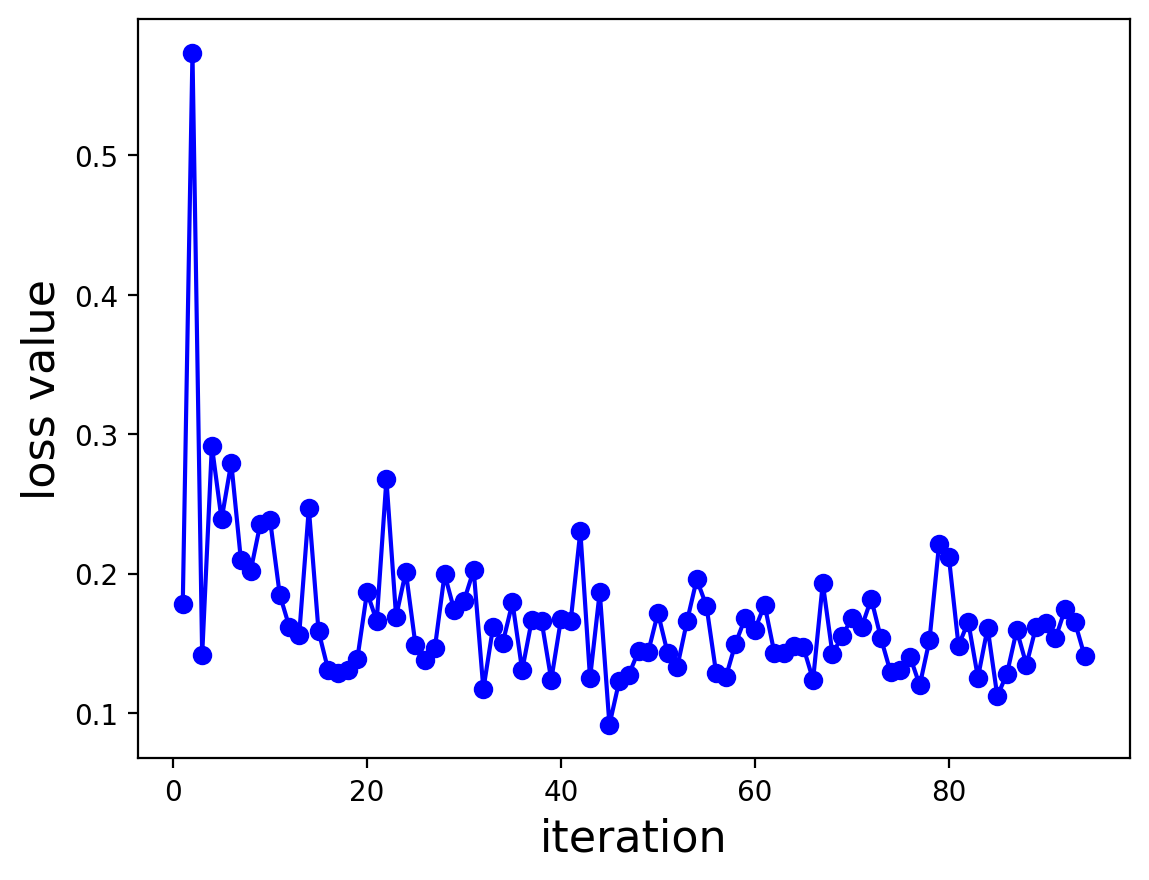

In [ ]:
model.config['train_epoch'] = 1
model.train(train, val, test)

# (참고) 약물 재창출

- drug repurposing
- 기존의 FDA허가 약물에 대해서 다른 질병(단백질)에 대한 효과를 예측
- DeepPurpose에서 제공하는 사전 학습된 DTI 모델을 사용한다
 - 다른 타겟 질병(단백질)과 기존의 허가 약물을 입력으로 넣어 상호작용을 예측

## 코로나 바이러스와 기존 약물의 결합을 예측

In [27]:
target, target_name = load_SARS_CoV_Protease_3CL() # SARS-CoV: 코로나바이러스
drug, drug_names = load_antiviral_drugs('./data', no_cid = True) # 항 바이러스 약물 데이터셋

### 데이터 확인

In [28]:
print('target_name :\t', target_name)
print('target :\t', target[:100], '...')
print('drug_names :\t', drug_names[:3], '...')
print('drug :\t\t', drug[:3], '...')

target_name :	 SARS-CoV 3CL Protease
target :	 SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKFSGDQWGDVLNLANNHEFEVVTQNGVTLNVVSRRLKGAVLILQTAVANAETPKYK ...
drug_names :	 ['Abacavir' 'Aciclovir' 'Adefovir'] ...
drug :		 ['C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)C4CC(C=C4)CO'
 'C1=NC2=C(N1COCCO)NC(=NC2=O)N' 'C1=NC(=C2C(=N1)N(C=N2)CCOCP(=O)(O)O)N'] ...


### 결합도 예측
- 사전학습 모델의 경로를 입력하지 않으면 DeepPurpose에서 제공하는 사전학습 모델이 사용됨

In [29]:
import DeepPurpose.oneliner as oneliner

oneliner.repurpose(*load_SARS_CoV2_Protease_3CL(), *load_antiviral_drugs(no_cid = True))

Save path not found or given and set to default: './save_folder/'. 
Loading customized repurposing dataset...
Beginning Downloading Pretrained Model...
Note: if you have already download the pretrained model before, please stop the program and set the input parameter 'pretrained_dir' to the path
pretrained model Successfully Downloaded...
Using pretrained model and making predictions...
repurposing...
Drug Target Interaction Prediction Mode...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81
encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Predictions from model 1 with drug encoding MPNN and target encoding CNN are done...
-------------
repurposing...
Drug Target Interaction Prediction Mode...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81
encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Predictions from model 2 with drug encoding CNN and target encoding CNN are done...
-------------
rep

### 약물 이름의 index를 찾아 약물 데이터 확인

In [30]:
target_name = 'Fosamprenavir'
print('drug name : ', target_name)
print('drug index : ', np.where(drug_names == target_name)[0][0])
print('drug smiles : ', drug[31])

drug name :  Fosamprenavir
drug index :  31
drug smiles :  CC(C)CN(CC(C(CC1=CC=CC=C1)NC(=O)OC2CCOC2)OP(=O)(O)O)S(=O)(=O)C3=CC=C(C=C3)N


## 보유 데이터로 학습된 모델을 통한 약물 재창출
- 보유한 약물-타겟 결합도 데이터로 모델을 학습시킨 후 약물 결합도 예측을 진행
- DeepPurpose에서 제공하는 사전학습 모델에 finetunning을 하는 방식

In [31]:
target, target_name = load_SARS_CoV_Protease_3CL() # SARS-CoV: 코로나바이러스
train_drug, train_target, train_y = load_AID1706_SARS_CoV_3CL('./data', seed = 1234) # 보유한 학습 데이터로 가정
drug, drug_names = load_antiviral_drugs('./data', no_cid = True) # 항 바이러스 약물 데이터셋

Beginning Processing...


/usr/local/lib/python3.10/dist-packages/DeepPurpose/dataset.py:364: DtypeWarning: Columns (0,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv(saved_path_data)
/usr/local/lib/python3.10/dist-packages/DeepPurpose/dataset.py:369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['binary_label'][(val.PUBCHEM_ACTIVITY_SCORE >= threshold) & (val.PUBCHEM_ACTIVITY_SCORE <=100)] = 1


Default binary threshold for the binding affinity scores is 15, recommended by the investigator
Done!


### 데이터 확인

In [32]:
train_drug, train_target, train_y

(array(['CCOC1=CC(=C(C=C1NC(=O)C2=CC=CO2)OCC)NC(=O)C3CCCCC3',
        'CCOC1=CC=C(C=C1)C(=O)NC2=CC=CC=C2N3CCOCC3',
        'CN(C1CCCC2=CC=CC=C12)C(=O)CN3CCN(CC3)C4=CC=CC=C4F', ...,
        'COC1=CC=C(C=C1)C(=O)OC2=CN=CC=C2',
        'C1CCC(CC1)C2=NC3=CC=CC=C3C(=N2)SCC(=O)NCC4=CC5=C(C=C4)OCO5',
        'C1=CC=C(C=C1)N2C=C(C(=N2)C3=CC=C(C=C3)F)NC(=O)CCl'], dtype='<U164'),
 'SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKFSGDQWGDVLNLANNHEFEVVTQNGVTLNVVSRRLKGAVLILQTAVANAETPKYKFVKANCGDSFTIACSYGGTVIGLYPVTMRSNGTIRASFLAGACGSVGFNIEKGVVNFFYMHHLELPNALHTGTDLMGEFYGGYVDEEVAQRVPPDNLVTNNIVAWLYAAIISVKESSFSQPKWLESTTVSIEDYNRWASDNGFTPFSTSTAITKLSAITGVDVCKLLRTIMVKSAQWGSDPILGQYNFEDELTPESVFNQVGGVRLQ',
 array([0, 0, 0, ..., 1, 0, 1]))

### 결합도 예측

In [ ]:
oneliner.repurpose(target = target,
                    target_name = target_name,
                    train_drug = train_drug,
                    train_target = train_target,
                    train_y = train_y,
                    X_repurpose = drug,
                    drug_names = drug_names,
                    save_dir = './save_folder',
                    finetune_batch_size = 128,
                    finetune_LR = 0.001,
                    finetune_epochs=10,
                    split='HTS',
                    convert_y = False,
                    frac=[0.8,0.1,0.1],
                    pretrained = False,
                    agg = 'max_effect')

Loading customized repurposing dataset...
Beginning Downloading Configs Files for training from scratch...
pretrained model Successfully Downloaded...
Training on your own customized data...
Drug Target Interaction Prediction Mode...
in total: 26640 drug-target pairs
encoding drug...
unique drugs: 13764
